In [1]:
from netCDF4 import Dataset
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as crs
from wrf import get_cartopy, getvar, latlon_coords, to_np, extract_times, ALL_TIMES

RUN_IDS = [46, 63, 45]
AHE_VAL = [0, 50, 100]
threshold_datetime = np.datetime64('2025-03-10')

template_dataset = Dataset(glob(f'/home/guc/runs/{RUN_IDS[0]:03}-*/wrfout*')[0])
template_var = getvar(template_dataset, "U10", timeidx=0)
times = extract_times(template_dataset, timeidx=ALL_TIMES)
times = times[times >= threshold_datetime]

In [2]:
results_u = {}
results_v = {}

for run_id in RUN_IDS:
    file_name = glob(f'/home/guc/runs/{run_id:03}-*/wrfout*')[0]
    dataset = Dataset(file_name)

    u_means = np.zeros(template_var.shape, dtype='float64')
    v_means = np.zeros(template_var.shape, dtype='float64')

    for time_idx, date_time in enumerate(times):
        print(f'Processing run ID={run_id}, {date_time}', end='\r')
        u_data = getvar(dataset, "U10", timeidx=time_idx)
        v_data = getvar(dataset, "V10", timeidx=time_idx)

        u_means += to_np(u_data)
        v_means += to_np(v_data)

    results_u[run_id] = u_means
    results_v[run_id] = v_means

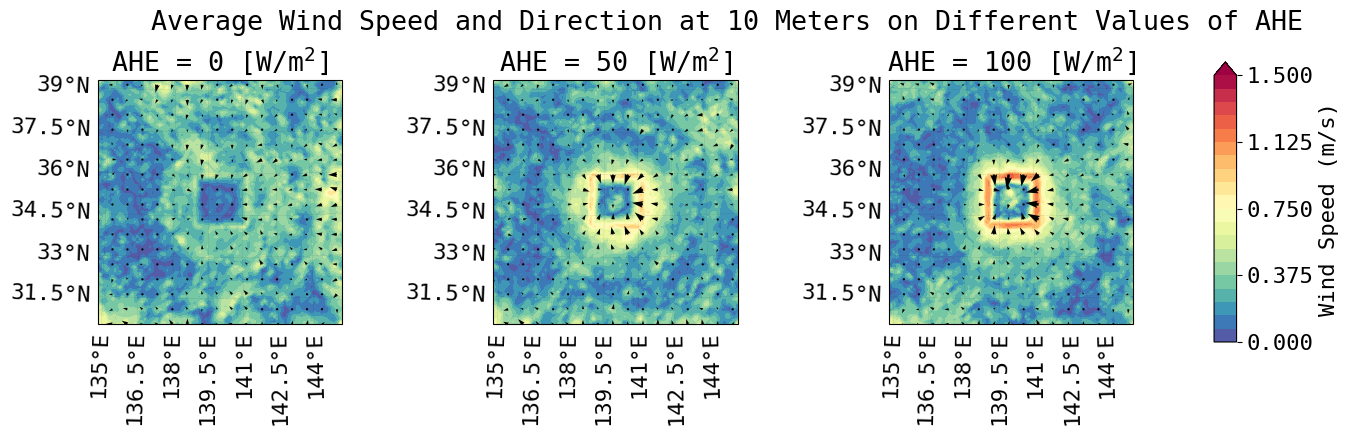

In [15]:
plt.rcParams["font.family"] = "DejaVu Sans Mono"
plt.rcParams["font.size"] = 16

plot_lim = np.linspace(0, 1.5, 21)

z_data = getvar(template_dataset, "z", timeidx=0)
lats, lons = latlon_coords(z_data)
cart_proj = get_cartopy(z_data)

column_size = len(RUN_IDS)

fig, axes = plt.subplots(1, column_size, figsize=(15, 4), subplot_kw={'projection': cart_proj})
fig.tight_layout(pad=3.5)

for idx, run_id in enumerate(RUN_IDS):
    i, j = idx // column_size, idx % column_size

    u = results_u[run_id] / len(times)
    v = results_v[run_id] / len(times)
    var = np.sqrt(u**2 + v**2)

    gridlines = axes[j].gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        x_inline=False,
        y_inline=False,
        linewidth=0.1,
        color="black",
        linestyle="dotted",
    )
    gridlines.top_labels = None
    gridlines.right_labels = None

    contour = axes[j].contourf(
        to_np(lons),
        to_np(lats),
        var,
        plot_lim,
        cmap="Spectral_r",
        extend='max',
        transform=crs.PlateCarree()
    )

    mask = (slice(None, None, 6), slice(None, None, 6))

    axes[j].set_title(f'AHE = {AHE_VAL[idx]} [W/m$^2$]')
    axes[j].quiver(
        to_np(lons)[mask],
        to_np(lats)[mask],
        to_np(u)[mask],
        to_np(v)[mask],
        transform=crs.PlateCarree(),
        scale=20,
        width=0.01
    )

    if i == 0 and j == column_size - 1:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes((0.825, 0.15, 0.015, 0.7))
        cbar = fig.colorbar(contour, cax=cbar_ax, ticks=plot_lim[::5])
        cbar.ax.set_ylabel('Wind Speed (m/s)')

fig.suptitle(f"Average Wind Speed and Direction at 10 Meters on Different Values of AHE")
plt.savefig('/home/guc/results/var-comparison/wind-speed-dir.svg')